In [3]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from tqdm import tqdm

In [ ]:


# ==============================
# PARAMETERS
# ==============================
EXPORT_INTERVAL = 0.16          # Frame rate (seconds)
DIST_THRESH = 3             # Distance threshold for potential conflict (meters)
PED_BOX = (0.3, 0.3)            # Pedestrian bounding box (length, width in meters)
CAR_BOX = (3.72, 1.44)         # car bounding box
SPEED_THRESHOLD = 4           # Minimum speed (m/s) to be considered "moving"
MIN_STOP_DURATION = 1.0         # Duration threshold to define "stopped" vehicles (seconds)

# ==============================
# STEP 1: LOAD DATA
# ==============================
df_ped = pd.read_csv(r"D:\T\test_codeEVT\nd\ped_smooth.csv")
df_car = pd.read_csv(r"D:\T\test_codeEVT\nd\car_smooth.csv")
# ==============================
# STEP 2: FILTER OUT STOPPED CARRCYCLES
# ==============================
# Compute carr speed
df_car['speed'] = np.sqrt(df_car['vx_smooth']**2 + df_car['vy_smooth']**2)

# Filter function
def filter_stopped_vehicles(df, speed_col='speed', time_col='TimeStamp'):
    df = df.copy()
    df['time_diff'] = df.groupby('Track ID')[time_col].diff()
    df['is_stopped'] = df[speed_col] < SPEED_THRESHOLD
    stop_groups = (df['is_stopped'] != df['is_stopped'].shift()).cumsum()
    df['stop_duration'] = df.groupby(['Track ID', stop_groups])['time_diff'].cumsum()
    filtered_df = df[~((df['is_stopped']) & (df['stop_duration'] >= MIN_STOP_DURATION))]
    return filtered_df.drop(columns=['time_diff', 'is_stopped', 'stop_duration'])

df_car = filter_stopped_vehicles(df_car)

# ==============================
# STEP 3: PREPROCESSING
# - Round timestamps
# - Compute heading from smoothed velocity
# ==============================
df_ped['TimeStamp_rounded'] = np.round(df_ped['TimeStamp'] / EXPORT_INTERVAL) * EXPORT_INTERVAL
df_car['TimeStamp_rounded'] = np.round(df_car['TimeStamp'] / EXPORT_INTERVAL) * EXPORT_INTERVAL

df_ped['heading'] = np.degrees(np.arctan2(df_ped['vy_smooth'], df_ped['vx_smooth'])) % 360
df_car['heading'] = np.degrees(np.arctan2(df_car['vy_smooth'], df_car['vx_smooth'])) % 360



In [49]:
print(df_car)

      Unnamed: 0  Track ID  TimeStamp  Type          X           Y    dx  \
4387        4453       374     117.44   Car  778901.23  1435731.89   NaN   
4388        4454       374     117.60   Car  778901.17  1435731.90 -0.06   
4389        4455       374     117.76   Car  778901.12  1435731.91 -0.05   
4390        4456       374     117.92   Car  778901.06  1435731.91 -0.06   
4391        4457       374     118.08   Car  778900.99  1435731.92 -0.07   
...          ...       ...        ...   ...        ...         ...   ...   
4556        4622       374     144.48   Car  778844.95  1435742.41 -0.71   
4557        4623       374     144.64   Car  778844.48  1435742.20 -0.47   
4558        4624       374     144.80   Car  778844.30  1435742.12 -0.18   
4559        4625       374     144.96   Car  778844.28  1435742.11 -0.02   
4560        4626       374     145.12   Car  778844.29  1435742.12  0.01   

        dy      vx      vy  ...  dx_smooth       x_smooth       dvx       dvy  \
4387  

In [55]:

# ==============================
# STEP 4: FUNCTION - GET ROTATED BOUNDING BOX CORNERS
# ==============================
def get_all_rotated_corners(df, box_dim):
    half_l, half_w = box_dim[0] / 2, box_dim[1] / 2
    base_corners = np.array([
        [half_l, half_w],
        [half_l, -half_w],
        [-half_l, -half_w],
        [-half_l, half_w]
    ])
    headings_rad = np.radians(df['heading'].values)
    cos = np.cos(headings_rad)
    sin = np.sin(headings_rad)

    rotated = np.empty((len(df), 4, 2))
    for i in range(4):
        x = base_corners[i, 0]
        y = base_corners[i, 1]
        rotated[:, i, 0] = x * cos - y * sin + df['x_smooth'].values
        rotated[:, i, 1] = x * sin + y * cos + df['y_smooth'].values
    return rotated

# ==============================
# STEP 5: PAIRWISE CONFLICT DETECTION
# - For each pedestrian-carrcycle pair:
#     - Align timestamps
#     - Check center distance
#     - Calculate minimum corner distance
#     - Compute closing rate and ATTC
# ==============================
conflict_rows = []
ped_ids = df_ped['Track ID'].unique()
car_ids = df_car['Track ID'].unique()

for ped_id in tqdm(ped_ids, desc="Processing pedestrian–car pairs"):
    ped = df_ped[df_ped['Track ID'] == ped_id].copy()
    ped_corners_all = get_all_rotated_corners(ped, PED_BOX)
    ped_times = ped['TimeStamp_rounded'].values
    ped_xy = ped[['x_smooth', 'y_smooth']].values

    for car_id in car_ids:
        car = df_car[df_car['Track ID'] == car_id].copy()
        car_corners_all = get_all_rotated_corners(car, CAR_BOX)
        car_times = car['TimeStamp_rounded'].values
        car_xy = car[['x_smooth', 'y_smooth']].values

        # Exact timestamp matches only
        time_diffs = np.abs(ped_times[:, None] - car_times[None, :])
        time_matches = time_diffs <= 0.0

        # Euclidean distance between centers
        center_dists = np.hypot(
            ped_xy[:, 0, None] - car_xy[None, :, 0],
            ped_xy[:, 1, None] - car_xy[None, :, 1]
        )

        conflict_mask = (time_matches) & (center_dists <= DIST_THRESH)
        ped_idx, car_idx = np.where(conflict_mask)

        for p_idx, m_idx in zip(ped_idx, car_idx):
            ped_row = ped.iloc[p_idx]
            car_row = car.iloc[m_idx]
            min_dist = cdist(ped_corners_all[p_idx], car_corners_all[m_idx]).min()

            if min_dist == 0:
                closing_rate = 0
            else:
                dist_matrix = cdist(ped_corners_all[p_idx], car_corners_all[m_idx])
                min_idx = np.unravel_index(np.argmin(dist_matrix), dist_matrix.shape)
                direction_vec = car_corners_all[m_idx][min_idx[1]] - ped_corners_all[p_idx][min_idx[0]]
                unit_vec = direction_vec / min_dist

                rel_v = np.array([
                    ped_row['vx_smooth'] - car_row['vx_smooth'],
                    ped_row['vy_smooth'] - car_row['vy_smooth']
                ])
                rel_a = 0.5 * np.array([
                    ped_row['ax'] - car_row['ax'],
                    ped_row['ay'] - car_row['ay']
                ])

                closing_rate = -np.dot(rel_v, unit_vec) + np.dot(rel_a, unit_vec)

            attc = min_dist / closing_rate if closing_rate > 0 else np.inf

            conflict_rows.append({
                'Ped_ID': ped_id,
                'Car_ID': car_id,
                'Ped_Time': ped_row['TimeStamp'],
                'Car_Time': car_row['TimeStamp'],
                'Ped_X': ped_row['x_smooth'],
                'Ped_Y': ped_row['y_smooth'],
                'Car_X': car_row['x_smooth'],
                'Car_Y': car_row['y_smooth'],
                'Min_Corner_Distance': min_dist,
                'Closing_Rate': closing_rate,
                'ATTC': attc,
                'Ped_Heading': ped_row['heading'],
                'Car_Heading': car_row['heading']
            })

# ==============================
# STEP 6: EXPORT FINAL RESULTS
# ==============================
results_df = pd.DataFrame(conflict_rows)
print(results_df.head())
results_df.to_csv("ped_car_attc_results.csv", index=False)

Processing pedestrian–car pairs: 100%|██████████| 322/322 [00:32<00:00,  9.76it/s]

   Ped_ID  Car_ID  Ped_Time  Car_Time          Ped_X         Ped_Y  \
0    1285    1348    473.72    473.76  778896.059858  1.435732e+06   
1    1285    1348    473.88    473.92  778896.099990  1.435732e+06   
2    1285    1348    474.04    474.08  778896.152401  1.435732e+06   
3    1285    1348    474.20    474.24  778896.203322  1.435732e+06   
4    1285    1348    474.36    474.40  778896.241313  1.435732e+06   

           Car_X         Car_Y  Min_Corner_Distance  Closing_Rate       ATTC  \
0  778897.760000  1.435732e+06             0.514022           NaN        inf   
1  778897.720000  1.435732e+06             0.529479     -0.033133        inf   
2  778897.680000  1.435732e+06             0.530783      0.043226  12.279160   
3  778897.646250  1.435732e+06             0.369116      0.636934   0.579520   
4  778897.614821  1.435732e+06             0.494954      0.393933   1.256442   

   Ped_Heading  Car_Heading  
0   338.658365   180.000000  
1   346.295104   180.000000  
2   349.

In [57]:
print(results_df[results_df['Car_ID']==374])

Empty DataFrame
Columns: [Ped_ID, Car_ID, Ped_Time, Car_Time, Ped_X, Ped_Y, Car_X, Car_Y, Min_Corner_Distance, Closing_Rate, ATTC, Ped_Heading, Car_Heading]
Index: []


In [8]:
output= results_df[(results_df['Min_Corner_Distance']<1) & (results_df['ATTC']<1)]
unique_pairs = output[['Ped_ID', 'Car_ID']].drop_duplicates()
print(f"\nNumber of unique Ped_ID-Car_ID pairs: {len(unique_pairs)}")
print(unique_pairs[['Ped_ID', 'Car_ID']])



Number of unique Ped_ID-Car_ID pairs: 7
    Ped_ID  Car_ID
3     1285    1348
12    1524    1559
15    1638    1374
24    2061    2161
37    2190    2081
61    2310    2463
97    3326    3338


# approach2

In [52]:
def calculate_closing_rate(ped_row, car_row):
    """Calculate closing rate using vector projection method"""
    # Relative position vector (pedestrian to car)
    rel_x = ped_row['x_smooth'] - car_row['x_smooth']
    rel_y = ped_row['y_smooth'] - car_row['y_smooth']
    distance = np.hypot(rel_x, rel_y)
    
    if distance == 0:
        return 0  # Collision already occurring
    
    # Unit vector in direction of shortest distance
    u_x = rel_x / distance
    u_y = rel_y / distance
    
    # Relative velocity components
    rel_vx = ped_row['vx_smooth'] - car_row['vx_smooth']
    rel_vy = ped_row['vy_smooth'] - car_row['vy_smooth']
    
    # Closing rate is negative dot product (positive when closing)
    closing_rate = -(rel_vx * u_x + rel_vy * u_y)
    return closing_rate 


# ==============================
# STEP 4: FUNCTION - GET ROTATED BOUNDING BOX CORNERS
# ==============================
def get_all_rotated_corners(df, box_dim):
    half_l, half_w = box_dim[0] / 2, box_dim[1] / 2
    base_corners = np.array([
        [half_l, half_w],
        [half_l, -half_w],
        [-half_l, -half_w],
        [-half_l, half_w]
    ])
    headings_rad = np.radians(df['heading'].values)
    cos = np.cos(headings_rad)
    sin = np.sin(headings_rad)

    rotated = np.empty((len(df), 4, 2))
    for i in range(4):
        x = base_corners[i, 0]
        y = base_corners[i, 1]
        rotated[:, i, 0] = x * cos - y * sin + df['x_smooth'].values
        rotated[:, i, 1] = x * sin + y * cos + df['y_smooth'].values
    return rotated

# ==============================
# STEP 5: PAIRWISE CONFLICT DETECTION
# - For each pedestrian-car pair:
#     - Align timestamps
#     - Check center distance
#     - Calculate minimum corner distance
#     - Compute closing rate and ATTC
# ==============================
conflict_rows = []
ped_ids = df_ped['Track ID'].unique()
car_ids = df_car['Track ID'].unique()

for ped_id in tqdm(ped_ids, desc="Processing pedestrian–car pairs"):
    ped = df_ped[df_ped['Track ID'] == ped_id].copy()
    ped_corners_all = get_all_rotated_corners(ped, PED_BOX)
    ped_times = ped['TimeStamp_rounded'].values
    ped_xy = ped[['x_smooth', 'y_smooth']].values

    for car_id in car_ids:
        car = df_car[df_car['Track ID'] == car_id].copy()
        car_corners_all = get_all_rotated_corners(car, CAR_BOX)
        car_times = car['TimeStamp_rounded'].values
        car_xy = car[['x_smooth', 'y_smooth']].values

        # Exact timestamp matches only
        time_diffs = np.abs(ped_times[:, None] - car_times[None, :])
        time_matches = time_diffs <= 0.0

        # Euclidean distance between centers
        center_dists = np.hypot(
            ped_xy[:, 0, None] - car_xy[None, :, 0],
            ped_xy[:, 1, None] - car_xy[None, :, 1]
        )

        conflict_mask = (time_matches) & (center_dists <= DIST_THRESH)
        ped_idx, car_idx = np.where(conflict_mask)

        for p_idx, m_idx in zip(ped_idx, car_idx):
            ped_row = ped.iloc[p_idx]
            car_row = car.iloc[m_idx]
            min_dist = cdist(ped_corners_all[p_idx], car_corners_all[m_idx]).min()

            if min_dist == 0:
                closing_rate = 0
            else:
                closing_rate = calculate_closing_rate(ped_row, car_row)

            center_dist = center_dists[p_idx, m_idx]
            attc = center_dist / closing_rate if closing_rate > 0 else np.inf


            conflict_rows.append({
                'Ped_ID': ped_id,
                'Car_ID': car_id,
                'Ped_Time': ped_row['TimeStamp'],
                'Car_Time': car_row['TimeStamp'],
                'Ped_X': ped_row['x_smooth'],
                'Ped_Y': ped_row['y_smooth'],
                'Car_X': car_row['x_smooth'],
                'Car_Y': car_row['y_smooth'],
                'Min_Corner_Distance': min_dist,
                'Closing_Rate': closing_rate,
                'ATTC': attc,
                'Ped_Heading': ped_row['heading'],
                'Car_Heading': car_row['heading']
            })

# ==============================
# STEP 6: EXPORT FINAL RESULTS
# ==============================
results_df = pd.DataFrame(conflict_rows)
print(results_df.head())

Processing pedestrian–car pairs: 100%|██████████| 322/322 [00:32<00:00, 10.00it/s]

   Ped_ID  Car_ID  Ped_Time  Car_Time          Ped_X         Ped_Y  \
0    1285    1348    473.72    473.76  778896.059858  1.435732e+06   
1    1285    1348    473.88    473.92  778896.099990  1.435732e+06   
2    1285    1348    474.04    474.08  778896.152401  1.435732e+06   
3    1285    1348    474.20    474.24  778896.203322  1.435732e+06   
4    1285    1348    474.36    474.40  778896.241313  1.435732e+06   

           Car_X         Car_Y  Min_Corner_Distance  Closing_Rate      ATTC  \
0  778897.760000  1.435732e+06             0.514022      0.398090  4.274768   
1  778897.720000  1.435732e+06             0.529479      0.497005  3.263881   
2  778897.680000  1.435732e+06             0.530783      0.572702  2.672350   
3  778897.646250  1.435732e+06             0.369116      0.519984  2.782961   
4  778897.614821  1.435732e+06             0.494954      0.429083  3.212410   

   Ped_Heading  Car_Heading  
0   338.658365   180.000000  
1   346.295104   180.000000  
2   349.283786

In [53]:
print(results_df[results_df['Ped_ID']==382])

Empty DataFrame
Columns: [Ped_ID, Car_ID, Ped_Time, Car_Time, Ped_X, Ped_Y, Car_X, Car_Y, Min_Corner_Distance, Closing_Rate, ATTC, Ped_Heading, Car_Heading]
Index: []


In [59]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

# Parameters
SPEED_THRESHOLD = 4  # m/s
MIN_STOP_DURATION = 1.0  # seconds
DIST_THRESH = 2
EXPORT_INTERVAL = 0.16  # seconds
PED_BOX = (0.3, 0.3)
CAR_BOX = (3.72, 1.44)         

# ----------------------------------
# Helpers
# ----------------------------------

def filter_stopped_vehicles(df, speed_col='speed', time_col='TimeStamp'):
    """Filter out stopped vehicles longer than threshold"""
    df = df.copy()
    df['time_diff'] = df.groupby('Track ID')[time_col].diff()
    df['is_stopped'] = df[speed_col] < SPEED_THRESHOLD
    stop_groups = (df['is_stopped'] != df['is_stopped'].shift()).cumsum()
    df['stop_duration'] = df.groupby(['Track ID', stop_groups])['time_diff'].cumsum()
    return df[~((df['is_stopped']) & (df['stop_duration'] >= MIN_STOP_DURATION))].drop(columns=['time_diff', 'is_stopped', 'stop_duration'])

def get_rotated_corners(x, y, heading, length, width):
    """Return coordinates of rotated bounding box corners"""
    half_l, half_w = length / 2, width / 2
    corners = np.array([
        [ half_l,  half_w],
        [ half_l, -half_w],
        [-half_l, -half_w],
        [-half_l,  half_w]
    ])
    rad = np.radians(heading)
    rot = np.array([
        [np.cos(rad), -np.sin(rad)],
        [np.sin(rad),  np.cos(rad)]
    ])
    return (corners @ rot.T) + np.array([x, y])

def get_closest_corners(row):
    """Get direction vector and min distance between closest corners"""
    ped_corners = get_rotated_corners(row['x_smooth_ped'], row['y_smooth_ped'], row['HA_ped'], *PED_BOX)
    car_corners = get_rotated_corners(row['x_smooth_car'], row['y_smooth_car'], row['HA_car'], *CAR_BOX)
    dists = cdist(ped_corners, car_corners)
    idx = np.unravel_index(np.argmin(dists), dists.shape)
    min_dist = dists[idx]
    direction_vec = car_corners[idx[1]] - ped_corners[idx[0]]
    return min_dist, direction_vec

def calculate_attc(row):
    """Compute ATTC using projection of relative motion on direction vector"""
    min_dist, direction_vec = get_closest_corners(row)
    norm = np.linalg.norm(direction_vec)
    if norm == 0:
        return np.inf
    unit_vec = direction_vec / norm

    rel_v = np.array([
        row['vx_smooth_ped'] - row['vx_smooth_car'],
        row['vy_smooth_ped'] - row['vy_smooth_car']
    ])
    rel_a = 0.5 * np.array([
        row['ax_ped'] - row['ax_car'],
        row['ay_ped'] - row['ay_car']
    ])

    closing_rate = -np.dot(rel_v, unit_vec) + np.dot(rel_a, unit_vec)
    return min_dist / closing_rate if closing_rate > 0 else np.inf

# ----------------------------------
# Load Data
# ----------------------------------

df_ped = pd.read_csv(r"D:\T\test_codeEVT\nd\ped_smooth.csv")
df_car = pd.read_csv(r"D:\T\test_codeEVT\nd\car_smooth.csv")
df_car['speed'] = np.sqrt(df_car['vx_smooth']**2 + df_car['vy_smooth']**2)

# Filter stopped vehicles
print(f"Original carrcycle count: {len(df_car)}")
df_car = filter_stopped_vehicles(df_car, speed_col='speed')
print(f"Filtered carrcycle count: {len(df_car)}")

# Calculate yaw rates
for df in [df_ped, df_car]:
    df['yaw_rate'] = df.groupby('Track ID').apply(
        lambda x: x['HA'].diff() / x['TimeStamp'].diff()
    ).reset_index(level=0, drop=True)

# Round timestamps
df_ped['Time_rounded'] = (df_ped['TimeStamp'] / EXPORT_INTERVAL).round() * EXPORT_INTERVAL
df_car['Time_rounded'] = (df_car['TimeStamp'] / EXPORT_INTERVAL).round() * EXPORT_INTERVAL


Original carrcycle count: 329613
Filtered carrcycle count: 39660


C:\Users\IST LAB 1\AppData\Local\Temp\ipykernel_9492\233842656.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['yaw_rate'] = df.groupby('Track ID').apply(
C:\Users\IST LAB 1\AppData\Local\Temp\ipykernel_9492\233842656.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['yaw_rate'] = df.groupby('Track ID').apply(


In [60]:

# ----------------------------------
# Merge and Process
# ----------------------------------

merged = pd.merge(
    df_ped, 
    df_car, 
    on='Time_rounded', 
    suffixes=('_ped', '_car')
)

merged['Center_dist'] = np.hypot(
    merged['x_smooth_ped'] - merged['x_smooth_car'],
    merged['y_smooth_ped'] - merged['y_smooth_car']
)

# Filter by center threshold
results = merged[merged['Center_dist'] <= DIST_THRESH].copy()

# Calculate ATTC using corrected method
results['ATTC'] = results.apply(calculate_attc, axis=1)

# Output
output = results[['Track ID_ped', 'Track ID_car', 'TimeStamp_ped', 'ATTC']].rename(columns={
    'Track ID_ped': 'Ped_ID',
    'Track ID_car': 'car_ID',
    'TimeStamp_ped': 'TimeStamp'
})
print(output)

        Ped_ID  car_ID  TimeStamp       ATTC
5605      1285    1348     473.72        inf
5608      1285    1348     473.88        inf
5611      1285    1348     474.04  12.279160
5614      1285    1348     474.20   0.579520
5616      1285    1348     474.36   1.256442
...        ...     ...        ...        ...
181608   16153   15932    5512.88        inf
181609   16153   15932    5512.88        inf
181610   16153   15932    5513.04   0.134869
181611   16153   15932    5513.04   1.725885
181651   16153   15932    5520.72   2.238916

[268 rows x 4 columns]


In [62]:
len(results[results['ATTC']<1][['Track ID_ped', 'Track ID_car']].drop_duplicates())

36

<Axes: >

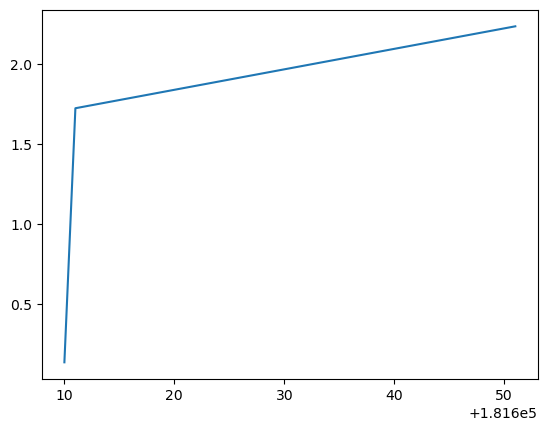

In [67]:
results[results['Track ID_ped']==16153]['ATTC'].plot()